# Application of Newton's methods for solving load flow problems

---


SETS
	
  $ \Omega _B $ Nodes.

  $ \Omega _L $ Branch.

PARAMETERS

  $ r_{i,j}$ Resistance between node $ i $ and $ j $.

  $ x_{i,j} $ Impedance between node $ i $ and $ j $.

  $ tap_i $ Change of derivation in the transformer, located on the node $ i $.

  $ b^{shunt}_{ij} $ *Shunt* capacitor, located between the node $ i $ and $ j $.

  $ \theta_{i,j} $ Angle of tension, between the node $ i $ and $ j $.
 
VARIABLES
  
  $ V_{b} $                      Voltage at node $ b $.
                                 
  $ y_{i,j} $                    Admittance in the $ i, j $ branch.
                                 
  $ a_{i,j} $                    Analysis of the transformer's $ tap $, located in the $ i, j $ branch.
                                 
  $ g_{i,j} $                    Real part of the admittance in the $ i, j $ branch.
                                 
  $ b_{i,j} $                    Imaginary part of the admittance in the $ i, j $ branch.
                                 
  $ Y_{i,j} $                    Admittance matrix, with branch element $ i, j $.
                                 
  $ G_{i,j} $                    Real part of the admittance matrix in the $ i, j $ branch.
                                 
  $ B_{i,j} $                    Imaginary part of the admittance matrix in the $ i, j $ branch.
                                 
  $ P^{calc}_{b} $               Calculated active power, located at node $ b $.
                                 
  $ Q^{calc}_{b} $               Calculated reactive power, located at node $ b $.
                                 
  $ P^{esp}_{b} $                Expected active power, located at node $ b $.
                                 
  $ Q^{esp}_{b} $                Expected reactive power, located at node $ b $.
                                 
  $ \Delta P_{b} $               *Mismatches* matrix of active power.
                                 
  $ \Delta Q_{b} $               *Mismatches* matrix of reactive power.
                                 
  $ \Delta S_{b} $               *Mismatches* matrix of active and reactive powers.
                                 
  $ H_{i,j} $                    Jacobina H matrix element, representing the branch $ i, j $.
                                 
  $ N_{i,j} $                    Element of the matrix Jacobina N, representing the branch $ i, j $.
                                 
  $ M_{i,j} $                    Element of the Jacobina M matrix, representing the branch $ i, j $.
                                 
  $ L_{i,j} $                    Element of the Jacobina L matrix, representing the branch $ i, j $.
                                 
  $ J_{i,j} $                    Jacobina Matrix, representing the branch $ i, j $.
                                 
  $ \Delta V $                   Matrix *mismatches* of tension.
                                 
  $ \Delta \theta $              Matrix *mismatches* of the stage.

## Introduction


The calculations of the power flow are indispensable for the planning and operation of the electric power networks, this is due to the importance of having knowledge of the state of the network, the voltage and phase levels. Generally, these networks are represented in a simplified, single-line manner, and calculations are performed in pu. Another relevant aspect to this analysis is the choice of the method used, with some prioritizing computational time, but not guaranteeing the global optimum (heuristic methods) and others that prioritize the result, but consuming a lot of processing (linear).

The work of [Jabr (2006)](https://ieeexplore.ieee.org/document/1664986), presents an approach for calculating the power flow, based on the radial electrical energy distribution system. The problem was formulated to minimize losses and approached the problem in a conical way. The consequence work demonstrates the evolution of the need for interactions, with the increase of the used system, having also an increase in the computational time used to find a solution. [Milano (2009)](https://ieeexplore.ieee.org/document/4682629) also discusses this relationship, showing a possible approach to Newton's method, but discussing the variation of the error factor and the number of iterations necessary to find a solution.

[Tostado-Véliz, Kamel, Jurado (2019)](https://ieeexplore.ieee.org/document/8957953) did some research and presents a very detailed theoretical explanation of Newton's method. Demonstrating the possible divergence that the problem can assume, by the inversion of the Jacobina matrix. Adapting the method for large systems, where by the inversion of the Jacobian matrix, in addition to the extremely heavy problem, its computational time can suffer a divergence in an iteration, throwing out the whole process until that moment.

In this report will be presented the method of Complete Newton and Fast Decoupled, applied in the resolution of the load flow. Where the theory behind the methodology will be presented, carrying out tests and justifying which one is the fastest. Thus, the objective of this work is to buy these two methods, demonstrate mathematically which one is faster and with the results, justify them, with the tests being carried out in an electric power transmission system.

The work is written organized as follows: Chapter 2 is found in the explanation and simplifications adopted for Newton Decoupled Fast and Complete Newton. In Chapter 3, the test performed is found, using a transmission system and discussing the results found. In Chapter 4, you find a conclusion to the work.

In [5]:
#####################################################
####################  Libraries  ####################
#####################################################

import math
import numpy as np
from numpy.linalg import inv
import time

import numpy as np
import matplotlib.pyplot as plt

#####################################################
########  Loading and preparing branch data  ########
#####################################################

S_base = 100                                  
zeta = 10**-5                             
branch_txt = 'Rede_IEEE_14bus_ramos.txt'    
node_txt = 'Rede_IEEE_14bus_barras.txt'     

start_time = time.time()                    

data_branches = np.loadtxt(branch_txt, skiprows = 2)

if np.shape(data_branches) == (7,):
    data_branches = data_branches.reshape((1, 7))

TO =    data_branches[:,0]      
FROM =  data_branches[:,1]      
r =     data_branches[:,2]      
x =     data_branches[:,3]      
bsh =   data_branches[:,4]/2      
a =     data_branches[:,5]      
phi =   data_branches[:,6]      

#####################################################
######  Loading and preparing data from nodes  ######
#####################################################

node_data = np.loadtxt(node_txt, skiprows = 3)

NN = max(node_data[:,0])      
NN = int(NN)

bus = node_data[:,0]          
Type = node_data[:,1]   

V = node_data[:,2]            
theta = node_data[:,3]

P_G = node_data[:,4]/S_base    
Q_G = node_data[:,5]/S_base    
P_C = node_data[:,6]/S_base    
Q_C = node_data[:,7]/S_base    
B_shunt = node_data[:,8]/S_base 
P_nom = P_G - P_C               
Q_nom = Q_G - Q_C    

NN = int(max(max(TO),max(FROM)))    
NB = len(TO)                      

#####################################################
######  Loading and preparing data from nodes  ######
#####################################################

Y = np.zeros([NN,NN], dtype=complex)
tii = np.zeros([NB])
tjj = np.zeros([NB])
tij = np.zeros([NB])

for b in range(NN):  
    Y[b][b] = B_shunt[b] *1j;

for b in range(NB):
    i = int(TO[b])-1
    j = int(FROM[b])-1   
    
    ykm = 1/(r[b]+x[b]*1j)
 
    tii[b] = 1/(a[b]*a[b])
    tjj[b] = 1
    tij[b] = 1/ a[b]



    Y[i][i] = Y[i][i] + tii[b]*ykm+ 1j*bsh[b]
    Y[j][j] = Y[j][j]+ tjj[b]*ykm+ 1j*bsh[b]
    

    Y[i][j] = Y[i][j] - tij[b]*ykm
    Y[j][i] = Y[j][i] - tij[b]*ykm

G = np.real(Y)                
B = np.imag(Y)              

var = node_data[:,8:14]

PV = [i for i in range(len(Type)) if Type[i] == 1 or Type[i] == 2]
nPV = len(PV) 

PQ = [i for i in range(len(Type)) if Type[i] == 3]
nPQ = len(PQ) 

#####################################################
#########  Beginning the iterative process  #########
#####################################################

itera = 0 
maxDP = 10
maxDQ = 10

P_Calc =np.zeros_like(P_nom)
Q_Calc= np.zeros_like(Q_nom)

while (abs(maxDP) > zeta or abs(maxDQ) > zeta):    
    for i in range(NN):
        P_Calc[i] = G[i][i] * V[i] * V[i]
        Q_Calc[i] =-B[i][i] * V[i] * V[i] 
    
    for w in range(NB):    
        i = int(TO[w])-1
        j = int(FROM[w])-1        
    
        ykm= (r[w])/(r[w]**2+x[w]**2) - (x[w]*1j)/(r[w]**2+x[w]**2)
    
        g = np.real(ykm) * tij[w]
        b = np.imag(ykm) * tij[w]
    
        ab = theta[i]-theta[j]+ phi[w]    
    
        P_Calc[i] = P_Calc[i] + V[i] * V[j] * ( - g * math.cos(ab) - b * math.sin(ab))
        P_Calc[j] = P_Calc[j] + V[i] * V[j] * ( - g * math.cos(ab) + b * math.sin(ab))
        
        Q_Calc[i] = Q_Calc[i] + V[i] * V[j] * ( - g * math.sin(ab) + b * math.cos(ab))
        Q_Calc[j] = Q_Calc[j] - V[i] * V[j] * ( - g * math.sin(ab) - b * math.cos(ab))
        
    DP = np.zeros_like(P_nom)    
    DQ = np.zeros_like(Q_nom)
    
    maxDP = 0
    maxDQ = 0    
    
    for i in range(NN):        
        if Type[i]!= 3:
            DP[i] = P_nom[i] - P_Calc[i]
            
            if abs(DP[i]) > abs(maxDP):
                maxDP = DP[i]
                
        if Type[i]<= 1:
            DQ[i] = Q_nom[i] - Q_Calc[i]
            
            if abs(DQ[i]) > abs(maxDQ):
                maxDQ = DQ[i]    
    
    DS = np.transpose(np.r_[DP,DQ])    
    
    H = np.zeros((NN, NN))
    N = np.zeros((NN, NN))
    M = np.zeros((NN, NN)) 
    L = np.zeros((NN, NN))
    
    for i in range(NN):
        
        H[i][i] = -Q_Calc[i] - V[i] * V[i] * B[i][i]
    
        N[i][i] = P_Calc[i] + V[i] * G[i][i]
        M[i][i] = P_Calc[i] - V[i] * V[i] * G[i][i]
        L[i][i] = Q_Calc[i] - V[i] * B[i][i]
        
        if Type[i] == 3:
            H[i][i] = 10**0    
        
        if Type[i] >= 2:
            L[i][i] = 10**10
    
    for w in range(NB):    
        i = int(TO[w])-1
        j = int(FROM[w])-1        
        
        ab = theta[i]-theta[j]-(phi[w]*math.pi/180)
        
        H[i][j] = V[i] * V[j] * ( G[i][j] * math.sin(ab) - B[i][j] * math.cos(ab))
        H[j][i] = V[i] * V[j] * (-G[i][j] * math.sin(ab) - B[i][j] * math.cos(ab))
    
        N[i][j] = V[i] * (G[i][j] * math.cos(ab) + B[i][j] * math.sin(ab))
        N[j][i] = V[j] * (G[i][j] * math.cos(ab) - B[i][j] * math.sin(ab))
        
        M[i][j] =-V[i] * V[j] * (G[i][j] * math.cos(ab) + B[i][j] * math.sin(ab))
        M[j][i] =-V[i] * V[j] * (G[i][j] * math.cos(ab) - B[i][j] * math.sin(ab))
    
        L[i][j] = V[i] * (G[i][j] * math.sin(ab) - B[i][j] * math.cos(ab))
        L[j][i] = V[j] * (G[i][j] * math.sin(ab) - B[i][j] * math.cos(ab))    
        
    Jaux1 = np.hstack((H, N))
    Jaux2 = np.hstack((M, L))
    J = np.linalg.inv(np.vstack((Jaux1, Jaux2)))
    
    DV = np.dot(J,DS)
    d_theta = DV[:NN]                              
    dV = DV[NN:]         
    
    theta = d_theta + theta        
    V = dV + V    
    
    itera += 1
    if itera >= 200:
        print("Maximum number of iterations reached.")
        break    
        
total_time = time.time() - start_time

for k in range(NN):
    P_G[k] = P_Calc[k]+P_C[k]
    Q_G[k] = Q_Calc[k]+Q_C[k]
    
Pkm = np.zeros(NB)
Qkm = np.zeros(NB)
Pmk = np.zeros(NB)
Qmk = np.zeros(NB)
    
for w in range(NB):    
    k = int(TO[w])-1
    m = int(FROM[w])-1    

    ykm= (r[w])/(r[w]**2+x[w]**2) - (x[w]*1j)/(r[w]**2+x[w]**2)

    g = np.real(ykm)
    b = np.imag(ykm)
    
    ab = theta[k]-theta[m]-(phi[w]*math.pi/180)

    Pkm[w] = ((V[k]/a[w])**2)*g - V[k]*(V[m]/a[w])*(g*math.cos(ab) + b*math.sin(ab))
    Pmk[w] = (V[m]**2)*g - V[k]*(V[m]/a[w])*(g*math.cos(ab) - b*math.sin(ab))
    Qkm[w] = -((V[k]/a[w])**2)*(b + bsh[w]/2) + V[k]*(V[m]/a[w])*(b*math.cos(ab) - g*math.sin(ab))
    Qmk[w] = -(V[m]**2)*(b+bsh[w]/2) + V[k]*(V[m]/a[w])*(b*math.cos(ab) + g*math.sin(ab))

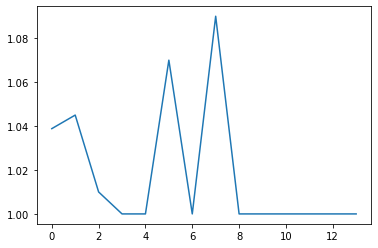

In [6]:
y = V
x = range(NN)

plt.plot(x, y)
plt.show()

In [4]:
>>> import wget
>>> url = 'https://labs.ece.uw.edu/pstca/pf14/ieee14cdf.txt'
>>> filename = wget.download(url)

100% [................................................................................] 4713 / 4713